# Spare-it Proof of Concept (PoC)

Before delving into the implementation of YOLOv8 for our Proof of Concept (PoC), it's crucial to consider a few key aspects regarding the dataset provided by Spare-it. There are notable characteristics we must address to ensure the success of our model.

Firstly, our dataset exhibits class imbalance, where certain recyclable classes are underrepresented or absent entirely. For instance, labels like "paper towel" may occur frequently, while others may be scarce. To mitigate this imbalance, we plan to do over sampling, under sampling, and data augmentation to handle class imbalances.

Furthermore, within our dataset, we encounter a distinction between material classes and specific names (e.g., "paper towel"). Notably, the material class serves as a superclass encompassing various specific names. Therefore, achieving optimal performance on these specific class names is crucial for enhancing the overall model accuracy.

Our initial step involves transforming Spare-it's dataset, currently in cocojson format, to align with the requirements of YOLOv8's dataset. Initially, we prioritize handling bounding boxes (bbox) and defer addressing segmentation aspects until we achieve satisfactory accuracy levels.

### Step 1. Create images and cocojson folders

Assuming this is run after the EDA notebook, you will first need to split the `images-and-labels` data into `images` and `cocojson` folders. As mentioned in our EDA, we have 11,666 labels and 16,326 image files. We will first need to add only images with the labels, meaning we should have 11,666 labels and images in each `images` and `cocojson` folder.

In [5]:
import os

# Print total number of json files
labels_path = './images-and-labels'
files = os.listdir(labels_path)
label_files = [file for file in files if file.endswith('.json')]
print(f"Number of .json files in the labels folder: {len(label_files)}")

# Print total number of image files
images_path = './images-and-labels'
files = os.listdir(images_path)
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']
image_files = [file for file in files if any(file.endswith(ext) for ext in image_extensions)]
print(f"Number of image files in the images folder: {len(image_files)}")

# We are looking for same named image files here
# This can be done because its common practice to keep the labels the same name as the image files
label_files_names = [os.path.splitext(label_file)[0] for label_file in label_files]
image_files_labeled = [filename + ext for filename in label_files_names for ext in image_extensions if filename + ext in image_files]

# As of 05/05/2024, we have 11,666 json files and matching images.
# label_files and image_files_labeled are what we are looking to download to other file.
import os
import shutil

# Write out the your directory to save labels and images
my_labels_path = './cocojson'
my_images_path = './images'

# Create the directories if it does not exist
os.makedirs(my_labels_path, exist_ok=True)
os.makedirs(my_images_path, exist_ok=True)

# Move labels to my_labels_path folder
for label_file in label_files:
    src = os.path.join(labels_path, label_file)
    dst = os.path.join(my_labels_path, label_file)
    shutil.move(src, dst)

print(f"{len(label_files)} label files moved to {my_labels_path}")

# Move images to my_images_path folder
for image_file in image_files_labeled:
    src = os.path.join(images_path, image_file)
    dst = os.path.join(my_images_path, image_file)
    shutil.move(src, dst)

print(f"{len(image_files_labeled)} image files moved to {my_images_path}")

Number of .json files in the labels folder: 11666
Number of image files in the images folder: 16326


### 2. Convert COCOJSON format annotations to YOLO format

You'll need to have the `images` folder with all the images and the `cocojson` folder with all the labels to run the code below.

Firstly, we need to obtain the `id_to_index` hash table. This is necessary because Spare-it uses annotations with different indexing, which doesn't increment by 1. This setup won't work with the YOLO format because YOLO format requires category ID values to increment by 1. To accommodate this, you'll have to create a `.yaml` file to run YOLOv8. Inside this `.yaml`, you can only increment the category ID by 1. Thus, we need to create a hash table to handle this issue and use Spare-it's COCOJSON format in the Ultralytics environment.

Below, we have presented three different `id_to_index` hash tables. The first one shows all the labels provided by Spare-it. The second one contains the top 20 labels selected based on count. However, neither of these yielded the desired high accuracy. The third set of labels was selected from the top 20 items with the highest recall rate, which resulted in the highest accuracy achieved so far.

We have three different hash tables because we experimented with various approaches. Initially, we attempted to use all 100 labels, but this didn't produce satisfactory results due to some items not occurring at all, leading to false positives. Subsequently, we tried the second hash table, which still had issues, such as the "Unclassifiable" label having many occurrences but a low recall rate. This prompted us to order items by recall rate, based on the results obtained from previous runs with the first and second hash tables. As a result, the third hash table, consisting of the top 20 labels by recall rate, yielded the highest accuracy for our model.

Since we are using a detection model, we need to handle bounding boxes (bbox) here.

In [1]:
import json
import os
import shutil

# Your directories
coco_dir = './cocojson'  # Directory containing COCO JSON files
labels_dir = './labels'  # Final directory to save the YOLO format files

# Remove exisiting labels folder if it exist
def delete_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
delete_directory(labels_dir)

# All labels. Use dataset.yaml for this.
# id_to_index = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9, 
#                14: 10, 15: 11, 16: 12, 17: 13, 18: 14, 19: 15, 115: 16, 114: 17, 
#                116: 18, 117: 19, 122: 20, 123: 21, 124: 22, 127: 23, 20: 24, 21: 25, 
#                22: 26, 23: 27, 24: 28, 25: 29, 26: 30, 27: 31, 30: 32, 125: 33, 126: 34, 
#                36: 35, 38: 36, 40: 37, 43: 38, 44: 39, 45: 40, 46: 41, 47: 42, 48: 43, 
#                49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 
#                58: 53, 59: 54, 60: 55, 120: 56, 121: 57, 63: 58, 65: 59, 66: 60, 67: 61, 
#                68: 62, 69: 63, 70: 64, 72: 65, 73: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 
#                82: 72, 83: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 118: 79, 119: 80, 89: 81, 
#                91: 82, 92: 83, 93: 84, 94: 85, 95: 86, 96: 87, 97: 88, 98: 89, 99: 90, 100: 91, 
#                101: 92, 102: 93, 103: 94, 106: 95, 107: 96, 109: 97, 110: 98, 112: 99}

# Top 20 labels with most count. Use dataset-top20-count.yaml for this.
# id_to_index = {
#     16: 0,
#     101: 1,
#     20: 2,
#     95: 3,
#     96: 4,
#     116: 5,
#     83: 6,
#     52: 7,
#     1: 8,
#     89: 9,
#     30: 10,
#     99: 11,
#     78: 12,
#     92: 13,
#     51: 14,
#     2: 15,
#     63: 16,
#     119: 17,
#     76: 18,
#     24: 19,
# }

# Top 20 labels with most recall rate. Use dataset-top20-recall.yaml for this. This is our best working model at the moment.
id_to_index = {
    63: 0,
    24: 1,
    89: 2,
    20: 3,
    1: 4,
    101: 5,
    51: 6,
    83: 7,
    76: 8,
    2: 9,
    78: 10,
    103: 11,
    85: 12,
    116: 13,
    16: 14,
    58: 15,
    77: 16,
    92: 17,
    84: 18,
    65: 19,
}

# I am basing this off from Ultralytics' JSON2YOLO. Check https://github.com/ultralytics/JSON2YOLO
# Reason building custom one is to have the id_to_index mapping within coco_to_yolo function.
def coco_to_yolo(coco_json_path, labels_dir, id_to_index):
    with open(coco_json_path) as f:
        data = json.load(f)
    
    # We will need image_width, image_height, and overall annotation here
    for image in data['images']:
        image_width, image_height = image['width'], image['height']
        yolo_annotations = [] # our converted yolo data format

        for annotation in data['annotations']:
            category_id = id_to_index.get(annotation['category_id'], None) # convert category_id using the id_to_index mapping
            if category_id is not None:
                x_min, y_min, bbox_width, bbox_height = annotation['bbox']
                x_center = x_min + (bbox_width / 2)
                y_center = y_min + (bbox_height / 2)
    
                x_center_normalized = x_center / image_width
                y_center_normalized = y_center / image_height
                width_normalized = bbox_width / image_width
                height_normalized = bbox_height / image_height
                if (
                    0 <= x_center_normalized <= 1
                    and 0 <= y_center_normalized <= 1
                    and 0 <= width_normalized <= 1
                    and 0 <= height_normalized <= 1
                ):
                    yolo_format = f"{category_id} {x_center_normalized} {y_center_normalized} {width_normalized} {height_normalized}"
                    yolo_annotations.append(yolo_format)
            else:
                continue # do something if if you want log something with skipping labels

        base_filename = os.path.splitext(os.path.basename(coco_json_path))[0]
        output_filename = os.path.join(labels_dir, f"{base_filename}.txt")
        
        # Write output into YOLO format
        with open(output_filename, 'w') as f:
            for item in yolo_annotations:
                f.write("%s\n" % item)


# Creates labels directory and iterate over all cocojson files to that folder
def convert_directory(coco_dir, labels_dir, id_to_index):
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)
        
    for filename in os.listdir(coco_dir):
        if filename.endswith(".json"):
            coco_json_path = os.path.join(coco_dir, filename)
            coco_to_yolo(coco_json_path, labels_dir, id_to_index)


convert_directory(coco_dir, labels_dir, id_to_index)

### 3. Generate datasets folder for training and validation testing

This code sets up the `datasets` folder for YOLOv8 to perform training and validation testing. We're using a detection model, so we've followed the instructions provided by [Ultralytics](https://docs.ultralytics.com/datasets/detect/).

We allocate 85% of the dataset to the `train` set and 15% to the `val` set.

In [3]:
import os
import shutil
import random

# remove exisiting datasets folder if it exist
def delete_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)      
delete_directory('./datasets')

# Generate YOLO custom dataset format for detection model
# Check here for detail: https://docs.ultralytics.com/datasets/detect/
subfolders = ['train', 'val']
for subfolder in subfolders:
    os.makedirs(os.path.join('./datasets', subfolder, 'images'), exist_ok=True)
    os.makedirs(os.path.join('./datasets', subfolder, 'labels'), exist_ok=True)

# Base dataset to create these splits
labels_path = './labels'
images_path = './images'
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

label_files = [file for file in os.listdir(labels_path) if file.endswith('.txt')]
# random.shuffle(label_files)  # Randomize the list

# Calculate split sizes
# Change the num_total to test smaller size.
num_total = len(label_files) # full 11k images
# num_total = 3000

num_train = int(num_total * 0.85) # 85% in training
num_val = num_total - num_train

# Split the files
train_files = label_files[:num_train]
val_files = label_files[num_train:num_total]

# Because we are only using 20 class labels, there could be empty annotations. So, we are handling here by skipping empty files.
def copy_files(files, source_path_images, source_path_labels, target_path_images, target_path_labels):
    for file in files:
        base_filename = os.path.splitext(file)[0]
        label_file_path = os.path.join(source_path_labels, file)

        # Check if the label file contains valid annotations
        with open(label_file_path, 'r') as f:
            annotations = f.read().strip()
        if not annotations:
            continue  # Skip copying this file as it has no valid annotations

        # Copy the image file if corresponding label file is not empty
        copied = False
        for ext in image_extensions:
            image_file = base_filename + ext
            if os.path.exists(os.path.join(source_path_images, image_file)):
                shutil.copy(os.path.join(source_path_images, image_file),
                            os.path.join(target_path_images, image_file))
                copied = True
                break  # stops after first match
        if not copied:
            print(f"No matching image found for {file}")
        else:
            shutil.copy(label_file_path, os.path.join(target_path_labels, file))  # Only add labels file if image exist.

# Copy files to respective directories
copy_files(train_files, images_path, labels_path, os.path.join('./datasets', 'train', 'images'), os.path.join('./datasets', 'train', 'labels'))
copy_files(val_files, images_path, labels_path, os.path.join('./datasets', 'val', 'images'), os.path.join('./datasets', 'val', 'labels'))

print(f"Total train files: {len(train_files)}")
print(f"Total valdiation files: {len(val_files)}")

Total train files: 9916
Total valdiation files: 1750


### 4. Batch distribution, Oversampling, and Undersampling

When running these codes, make sure to revisit the first and second blocks of the code to observe the difference in oversampling and undersampling effects on the dataset. If you need to reset the `dataset` folder, simply rerun the code block in our third step.

We are only focusing on the `/train/labels` folder because you typically apply sampling techniques or data augmentations only to the training set.

To briefly review each code block:

In the first block, we display the occurrences of each category ID that we have in our labels folder. This step is crucial for visualization of batch distribution and to determine the maximum value for sampling.

The second code block shows all the category IDs in five batches, depending on the batch size you choose. This helps determine the optimal batch size for the model.

In the third code block, we perform oversampling by duplicating the same labels and slightly altering the x and y positions.

In the fourth code block, we perform oversampling by simply deleting a number of labels.

In [2]:
# Get occurrences of each Category ID in training set
import os

def count_category_ids(label_files_directory):
    category_counts = {}
    label_files = [f for f in os.listdir(label_files_directory) if f.endswith('.txt')]

    # Iterate through each file and count category IDs
    for label_file in label_files:
        with open(os.path.join(label_files_directory, label_file), 'r') as file:
            for line in file:
                parts = line.strip().split()
                if not parts:
                    continue  # skip empty lines
                category_id = int(parts[0])
                if category_id in category_counts:
                    category_counts[category_id] += 1
                else:
                    category_counts[category_id] = 1

    return category_counts

# Path to the directory containing the training label files
train_labels_path = './datasets/train/labels'

# Print the category counts
category_counts = count_category_ids(train_labels_path)
for category_id, count in sorted(category_counts.items()):
    print(f"Category ID {category_id}: {count} occurrences")

Category ID 0: 6531 occurrences
Category ID 1: 24653 occurrences
Category ID 2: 2329 occurrences
Category ID 3: 1247 occurrences
Category ID 4: 2121 occurrences
Category ID 5: 1122 occurrences
Category ID 6: 3378 occurrences
Category ID 7: 1910 occurrences
Category ID 8: 8664 occurrences
Category ID 9: 5913 occurrences
Category ID 10: 3010 occurrences
Category ID 11: 645 occurrences
Category ID 12: 222 occurrences
Category ID 13: 1706 occurrences
Category ID 14: 880 occurrences
Category ID 15: 442 occurrences
Category ID 16: 194 occurrences
Category ID 17: 3194 occurrences
Category ID 18: 380 occurrences
Category ID 19: 2698 occurrences
Category ID 20: 401 occurrences


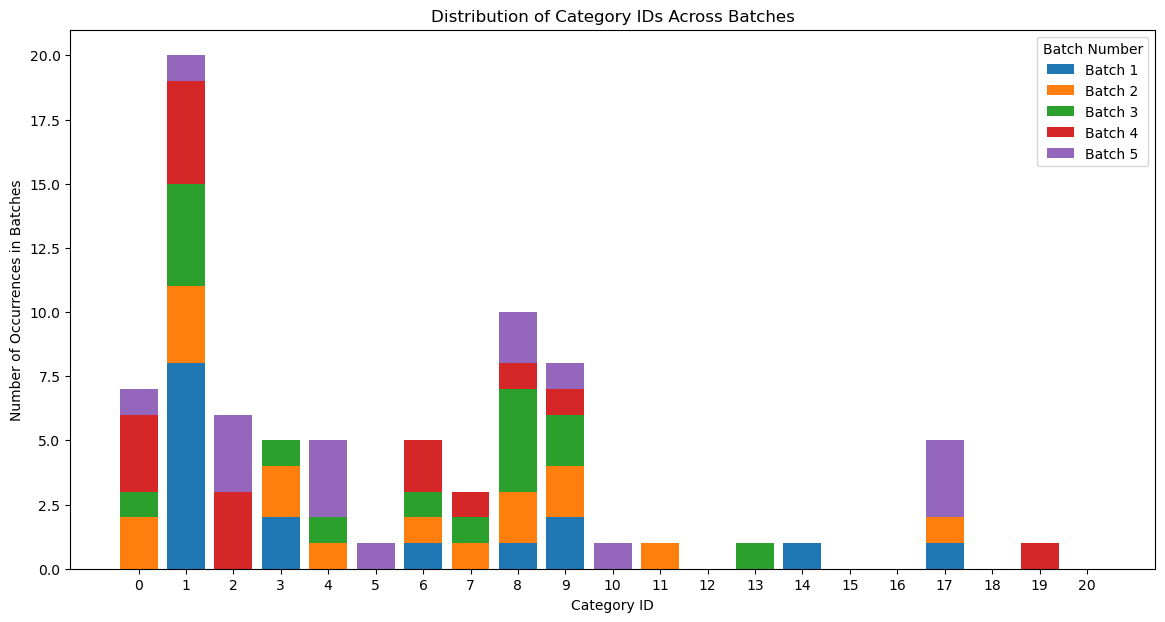

In [5]:
# See the batch distributions
import os
import random
import matplotlib.pyplot as plt

def simulate_batches(category_counts, batch_size, num_batches):
    # Create a list of category IDs repeated according to their counts
    all_ids = []
    for category_id, count in category_counts.items():
        all_ids += [category_id] * count
    
    # Shuffle the list to simulate random sampling
    random.shuffle(all_ids)
    
    # Distribute IDs into batches
    batches = [all_ids[i:i + batch_size] for i in range(0, len(all_ids), batch_size)]
    
    # Create a list to store category counts for each batch
    batch_distributions = []
    for batch in batches[:num_batches]:  # Limit to the first `num_batches` for visualization
        batch_count = {}
        for id in batch:
            if id in batch_count:
                batch_count[id] += 1
            else:
                batch_count[id] = 1
        batch_distributions.append(batch_count)
    
    return batch_distributions

def plot_batch_distributions(batch_distributions):
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 7))
    category_ids = sorted(category_counts.keys())
    for i, dist in enumerate(batch_distributions):
        counts = [dist.get(cid, 0) for cid in category_ids]
        ax.bar(category_ids, counts, bottom=[sum([batch_distributions[j].get(cid, 0) for j in range(i)]) for cid in category_ids], label=f'Batch {i + 1}')
    
    ax.set_xlabel('Category ID')
    ax.set_ylabel('Number of Occurrences in Batches')
    ax.set_title('Distribution of Category IDs Across Batches')
    ax.legend(title="Batch Number")
    plt.xticks(category_ids)
    plt.show()

# Simulate batches
batch_size = 16
num_batches = 5
batch_distributions = simulate_batches(category_counts, batch_size, num_batches)

# Plot the distribution across batches
plot_batch_distributions(batch_distributions)

In [4]:
# Over sampling
import os

# We are using 1/3 of max value to over sample because that is usually a good starting point.
# Please alter one_third_target variable to desired number if you want different size.
def calculate_factors(category_counts):
    # Determine the maximum count to match all categories to
    target_count = max(category_counts.values())
    one_third_target = target_count // 3 # Calculate 1/3 of the maximum count

    # Create a hash table for how many times to duplicate each entry
    factors = {}
    for cat_id, count in category_counts.items():
        required_count = one_third_target - count
        if required_count > 0:
            additional_copies = required_count // count
            factors[cat_id] = additional_copies
        else:
            factors[cat_id] = 0  # No duplication needed if the count is already at or above 1/3 target
    return factors

# Slightly adjusting the coordinates in x and y.
def modify_coordinates(parts, modification_index):
    x = float(parts[1])
    y = float(parts[2])
    w = float(parts[3])
    h = float(parts[4])

    increment = 0.0001 * modification_index # 0.0000001 is the smallest change it allows. Can't go more smaller.

    new_x = x + increment
    new_y = y + increment

    # Ensure the modified coordinates do not exceed 1.0
    new_x = min(new_x, 1.0)
    new_y = min(new_y, 1.0)
    return f"{parts[0]} {new_x} {new_y} {w} {h}\n"

# Over sample labels through duplicating
def oversample_labels(label_dir, factors):
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    for file in label_files:
        new_lines = []
        file_path = os.path.join(label_dir, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Append duplicates according to the factor, with slight modifications
        for line in lines:
            parts = line.strip().split()
            if not parts:
                continue  # skip empty lines
            category_id = int(parts[0])
            new_lines.append(line)  # append original coordinates
            
            # Create duplicates with slight modifications
            for i in range(factors.get(category_id, 0)):
                modified_line = modify_coordinates(parts, i + 1)
                new_lines.append(modified_line)

        # Rewrite the file
        with open(file_path, 'w') as f:
            f.writelines(new_lines)

label_dir = './datasets/train/labels'
factors = calculate_factors(category_counts)
print(sorted(category_counts.items()))
print(sorted(factors.items())) # this is the multiplier of over sampling
oversample_labels(label_dir, factors)

[(0, 6531), (1, 24653), (2, 2329), (3, 1247), (4, 2121), (5, 1122), (6, 3378), (7, 1910), (8, 8664), (9, 5913), (10, 3010), (11, 645), (12, 222), (13, 1706), (14, 880), (15, 442), (16, 194), (17, 3194), (18, 380), (19, 2698), (20, 401)]
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 2), (12, 8), (13, 0), (14, 1), (15, 3), (16, 9), (17, 0), (18, 4), (19, 0), (20, 4)]


In [53]:
# Under sampling
import os
import random

def undersample_labels(label_dir, category_id_to_reduce, target_count):
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    files_to_modify = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if int(parts[0]) == category_id_to_reduce:
                files_to_modify.append((label_file, line))

    # Shuffle the list to ensure random selection
    random.shuffle(files_to_modify)
    
    entries_to_remove = len(files_to_modify) - target_count
    lines_to_remove = set(random.sample(files_to_modify, entries_to_remove))

    # Remove the selected lines from lines_to_remove
    for label_file in label_files:
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as file:
            lines = file.readlines()
        with open(file_path, 'w') as file:
            for line in lines:
                if (label_file, line) not in lines_to_remove:
                    file.write(line)

    print(f"Reduced occurrences of Category ID {category_id_to_reduce} to {target_count}.")

# Specify the label directory and parameters for undersampling
label_dir = './datasets/train/labels'
category_id_to_reduce = 19 # Set your target category ID here
target_count = 3000  # Set your target count here

# Perform undersampling
undersample_labels(label_dir, category_id_to_reduce, target_count)

Reduced occurrences of Category ID 19 to 3000.


### 5. Model Generation

Now that we've completed setting up our datasets as desired, we'll proceed to train the model for recycle detection using YOLOv8, an open-source tool by Ultralytics.

We're utilizing Ultralytics YOLOv8, Albumentations, and Wandb. While you can stick with Ultralytics alone and perform tasks in the same manner, Albumentations offers more advanced data augmentation techniques. Additionally, wandb can serve as a valuable tool for tracking overall CPU/GPU consumption and result checking.

For our final model, we have used the basic data augmentations that YOLOv8 provides, with the following parameters:

- **`hsv_h` (Hue Adjustment)**: This controls the hue adjustment applied to the images. In our case, it’s set to `0.015`, which means the hue is adjusted slightly to introduce variability in the color of the objects.

- **`hsv_s` (Saturation Adjustment)**: This parameter adjusts the image saturation. Setting this to `0.7` increases or decreases the saturation, which helps in recognizing objects under different lighting conditions.

- **`hsv_v` (Value Adjustment)**: This adjusts the brightness of the image. A value of `0.4` modifies the brightness, aiding in adapting to different lighting situations.

- **`degrees` (Rotation)**: This parameter controls the image rotation in degrees. We've set it to `0.0` as rotation isn't necessary in our use case.

- **`translate` (Translation)**: The value `0.1` allows for slight shifting of the image horizontally and vertically, which helps in recognizing objects that are slightly off-center.

- **`scale` (Scaling)**: This scales the image by a factor of `0.5`. Scaling is useful for detecting objects of varying sizes.

- **`shear` (Shear Transform)**: Shear is set to `0.0` because our objects do not typically appear sheared.

- **`perspective` (Perspective Transform)**: The value `0.0` indicates no perspective transformation since our objects are generally viewed head-on.

- **`flipud` (Flip Up-Down)**: This parameter is set to `0.0` to disable vertical flipping, which isn't relevant to our data.

- **`fliplr` (Flip Left-Right)**: The value `0.5` allows for horizontal flipping, which helps in recognizing objects from either direction.

- **`bgr` (Channel Swap)**: This parameter is set to `0.0` because our color channel order doesn't need to be altered.

- **`mosaic` (Mosaic Augmentation)**: The value `1.0` enables mosaic augmentation, which combines multiple images into one, providing a richer training experience.

- **`mixup` (Mixup Augmentation)**: This is set to `0.0` because mixup isn't needed in our scenario.

- **`copy_paste` (Segment Copy-Paste)**: This parameter is set to `0.0` as we don't need to copy and paste objects in our segmentation tasks.

- **`auto_augment` (Automatic Augmentation)**: The value `randaugment` applies random augmentations, which introduces randomness into the training and helps generalize the model better.

- **`erasing` (Random Erasing)**: The value `0.4` introduces random erasing in the images, which helps in making the model more robust by ignoring certain areas.

- **`crop_fraction` (Crop Fraction)**: This parameter is set to `1.0` to retain the entire image without cropping.

For more advanced data augmentations, we can use the **Albumentations** library, which provides sophisticated augmentation techniques for images. To use Albumentations, we can set the `augment` parameter to `True` in the training configuration, and set all YOLOv8-specific data augmentation parameters to `0.0`. This setup allows for a more customized and diverse set of augmentations, enhancing the model's robustness and performance.

In [24]:
# Install Ultralytics, Albumentations, Wandb
!pip install -q ultralytics
# !pip install -q albumentations
# !pip install -q wandb

In [1]:
# import wandb
# wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ocmosk (jasonoh1998). Use `wandb login --relogin` to force relogin


True

In [ ]:
# # Use this sample code to use wandb after logging in above.

# from ultralytics import YOLO
# from wandb.integration.ultralytics import add_wandb_callback
# import wandb

# # Step 1: Initialize a Weights & Biases run
# wandb.init(project="ultralytics", job_type="training")

# # Step 2: Define the YOLOv8 Model and Dataset
# model = YOLO('yolov8n.pt')

# # Step 3: Add W&B Callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# # Step 4: Train and Fine-Tune the Model
# model.train(
# # Your train parameter
# )

# # Step 5: Validate the Model
# model.val()

# # Step 6: Perform Inference and Log Results
# model(["./images/Compost_000eeeeb-0444-4f74-91e3-d6329c6e9c85_ec3a2daf-29b4-4804-9216-e6a71b07a335_35addbdb-52aa-42ac-a9c7-26ed974484f7.jpeg"])

# # Step 7: Finalize the W&B Run
# wandb.finish()

In [ ]:
# # Data augmentation using Albumentations
# # Alter the T array to change data augmentations
# # Got insight from: https://medium.com/@k.sunman91/data-augmentation-on-ultralytics-for-training-yolov5-yolov8-97a8dab31fef
# from ultralytics.data.augment import Albumentations

# from ultralytics.utils import LOGGER, colorstr
# def __init__(self, p=1.0):
#         """Initialize the transform object for YOLO bbox formatted params."""
#         self.p = p
#         self.transform = None
#         prefix = colorstr("albumentations: ")
#         try:
#             import albumentations as A         

#             # Insert required transformation here
#             T = [         
#                 A.Rotate(limit=15, p=0.5),  # Moderate rotation
#                 A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),  # Lighting variation
#                 A.HorizontalFlip(p=0.5),  # Horizontal flip for symmetry
#                 A.GaussianBlur(blur_limit=(3, 7), p=0.2),  # Mild blur to simulate focus issues
#                 A.GaussNoise(var_limit=(10, 50), p=0.1),  # Simulate sensor noise
#             ]
#             self.transform = A.Compose(T, bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

#             LOGGER.info(prefix + ", ".join(f"{x}".replace("always_apply=False, ", "") for x in T if x.p))
#         except ImportError:  # package not installed, skip
#             pass
#         except Exception as e:
#             LOGGER.info(f"{prefix}{e}")
# Albumentations.__init__ = __init__

In [6]:
# Training model with YOLOv8
from ultralytics import YOLO
# model = YOLO('yolov8n.yaml') # example transfer learning
model = YOLO('yolov8n.pt')
# model = YOLO('yolov8n.yaml').load('yolov8n.pt') # example transfer learning

# these are some tuners you can use training for yolov8 https://github.com/ultralytics/ultralytics/blob/156b6be8d37f491a12600d68893ce29debc0caa1/ultralytics/engine/tuner.py#L85
# 'optimizer': tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
# "lr0": (1e-5, 1e-1),  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
# "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
# "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
# "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
# "warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
# "warmup_momentum": (0.0, 0.95),  # warmup initial momentum
# "box": (1.0, 20.0),  # box loss gain
# "cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
# "dfl": (0.4, 6.0),  # dfl loss gain
# "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
# "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
# "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
# "degrees": (0.0, 45.0),  # image rotation (+/- deg)
# "translate": (0.0, 0.9),  # image translation (+/- fraction)
# "scale": (0.0, 0.95),  # image scale (+/- gain)
# "shear": (0.0, 10.0),  # image shear (+/- deg)
# "perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
# "flipud": (0.0, 1.0),  # image flip up-down (probability)
# "fliplr": (0.0, 1.0),  # image flip left-right (probability)
# "bgr": (0.0, 1.0),  # image channel bgr (probability)
# "mosaic": (0.0, 1.0),  # image mixup (probability)
# "mixup": (0.0, 1.0),  # image mixup (probability)
# "copy_paste": (0.0, 1.0),  # segment copy-paste (probability)

model.train(
    project="ultralytics", # Destination of runs. If not provided, it will be in runs folder.
    data='dataset-top20-recall.yaml', # custom dataset
    device=0, # default = None
    epochs=200, # default 100
    imgsz=640, # default 640
    # optimizer='SGD', # Choose your optimizer
    batch=16, # Batch size
    patience=5, # default 100, Early stopping parameter
    # dropout=0.0, # default 0.0
    # augment=False, # Set this true and run if using Albumentation librabry.
    # cls=2,  # Increase classification loss weight https://github.com/ultralytics/ultralytics/issues/10207
    # box=13,  # Box loss weight
    # dfl=0.5,  # Default DFL weight,
    # label_smoothing=0.05,
    # hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, degrees=0.0, translate=0.0, scale=0.0, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.0, bgr=0.0, mosaic=0.0, mixup=0.0, copy_paste=0.0, erasing=0.0, crop_fraction=0.0, # data augmentations from YOLOv8
)

New https://pypi.org/project/ultralytics/8.2.5 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.37 🚀 Python-3.11.6 torch-2.1.2 CUDA:0 (NVIDIA L40S, 45589MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset-precise.yaml, epochs=200, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=ultralytics, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ocmosk (jasonoh1998). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /projectnb/spareit/jasonoh/datasets/train/labels... 9381 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9381/9381 [00:02<00:00, 3234.54it/s]

train: WARNING ⚠️ /projectnb/spareit/jasonoh/datasets/train/images/Trash_9a8023cc-2608-41e3-82ed-24e7507e91d5_b7e1275d-5d0e-48b8-af8f-254c49833370_c0f2c1b2-aea6-4cab-ba9a-52b06a92963f.jpeg: 1 duplicate labels removed


train: New cache created: /projectnb/spareit/jasonoh/datasets/train/labels.cache


val: Scanning /projectnb/spareit/jasonoh/datasets/val/labels... 1667 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1667/1667 [00:00<00:00, 2776.35it/s]

val: WARNING ⚠️ /projectnb/spareit/jasonoh/datasets/val/images/Trash_06e4cb92-5753-4a8a-bdc4-43ffad700922_07bd1196-c632-4bf4-a01f-35660b57d624_465ad689-8383-4ae0-b01f-015197a68b4b.jpeg: 1 duplicate labels removed


val: New cache created: /projectnb/spareit/jasonoh/datasets/val/labels.cache
Plotting labels to ultralytics/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ultralytics/train9
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.87G      1.513      3.487      1.456         47        640: 100%|██████████| 587/587 [04:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.50it/s]


                   all       1667      12871      0.335      0.129     0.0832     0.0497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.15G      1.489      2.527      1.447         48        640: 100%|██████████| 587/587 [04:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:19<00:00,  2.65it/s]


                   all       1667      12871      0.275      0.212      0.141     0.0879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.56G      1.538      2.436       1.47         65        640: 100%|██████████| 587/587 [04:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.55it/s]


                   all       1667      12871      0.327      0.185      0.137     0.0811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.11G      1.575      2.394      1.496         54        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.32it/s]


                   all       1667      12871      0.264      0.226      0.162     0.0977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.24G      1.534       2.28      1.472         73        640: 100%|██████████| 587/587 [04:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:24<00:00,  2.20it/s]


                   all       1667      12871      0.259      0.243      0.196      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.13G      1.517      2.195       1.46         73        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.32it/s]


                   all       1667      12871      0.335      0.271       0.21      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.22G      1.494      2.117      1.442         65        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.23it/s]


                   all       1667      12871      0.299      0.271      0.218      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200       2.6G      1.467      2.053       1.43         54        640: 100%|██████████| 587/587 [04:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.53it/s]


                   all       1667      12871      0.356      0.301      0.239       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.94G      1.451      2.015      1.421         61        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.31it/s]


                   all       1667      12871      0.332      0.318      0.263      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.28G      1.439      1.974      1.409         42        640: 100%|██████████| 587/587 [04:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.48it/s]


                   all       1667      12871      0.348      0.305      0.259      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.92G       1.43      1.937      1.401         46        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.25it/s]


                   all       1667      12871      0.347      0.312      0.262      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.99G      1.419      1.917      1.397         74        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.53it/s]


                   all       1667      12871      0.368      0.323      0.287      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.79G      1.419      1.907      1.393        100        640: 100%|██████████| 587/587 [04:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.36it/s]


                   all       1667      12871      0.345      0.323      0.272      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.07G      1.398      1.874      1.383         30        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.40it/s]


                   all       1667      12871      0.382      0.329      0.294      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.24G      1.394       1.85      1.376         52        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.39it/s]


                   all       1667      12871      0.383      0.348      0.311      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.95G      1.384      1.833      1.374         62        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.40it/s]


                   all       1667      12871       0.43      0.341       0.31        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.16G      1.376      1.818      1.368         85        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.37it/s]


                   all       1667      12871      0.406      0.352      0.317      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.11G      1.359      1.789      1.357         36        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.44it/s]


                   all       1667      12871       0.39      0.368      0.317      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.18G      1.367      1.781       1.36         57        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.25it/s]


                   all       1667      12871      0.434      0.359      0.329      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.03G       1.36      1.778      1.357         94        640: 100%|██████████| 587/587 [04:05<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.49it/s]


                   all       1667      12871      0.436      0.384      0.344      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.02G      1.348      1.759      1.347         55        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.30it/s]


                   all       1667      12871      0.423       0.36      0.328      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.76G       1.35       1.75      1.349         56        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.30it/s]


                   all       1667      12871      0.459      0.371      0.344      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.76G       1.35      1.741      1.348         49        640: 100%|██████████| 587/587 [05:07<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:30<00:00,  1.72it/s]


                   all       1667      12871      0.424      0.364      0.339      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.71G       1.34      1.724       1.34         53        640: 100%|██████████| 587/587 [06:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:27<00:00,  1.93it/s]


                   all       1667      12871      0.425      0.379      0.343      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.01G      1.338      1.717      1.338         96        640: 100%|██████████| 587/587 [04:56<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.51it/s]


                   all       1667      12871      0.436      0.385      0.354      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.59G      1.328      1.704      1.338         51        640: 100%|██████████| 587/587 [04:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.47it/s]


                   all       1667      12871      0.442      0.365      0.351      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.08G      1.324      1.697      1.332         56        640: 100%|██████████| 587/587 [05:47<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  1.98it/s]


                   all       1667      12871      0.443      0.397      0.364      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.71G      1.325      1.674       1.33        125        640: 100%|██████████| 587/587 [04:32<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.39it/s]


                   all       1667      12871      0.441      0.398      0.368      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.34G      1.319      1.676       1.33         45        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.28it/s]


                   all       1667      12871      0.448      0.404      0.376      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.69G       1.31      1.665      1.324         58        640: 100%|██████████| 587/587 [05:30<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.34it/s]


                   all       1667      12871      0.452      0.402       0.38      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.12G      1.314      1.654      1.322         37        640: 100%|██████████| 587/587 [04:09<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.36it/s]


                   all       1667      12871      0.454      0.405      0.379      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.39G      1.311      1.656      1.321         83        640: 100%|██████████| 587/587 [04:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.53it/s]


                   all       1667      12871      0.468      0.386      0.375      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.04G       1.31      1.641      1.316        124        640: 100%|██████████| 587/587 [06:14<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:27<00:00,  1.91it/s]


                   all       1667      12871      0.474      0.391      0.387      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.03G      1.297      1.631      1.311         85        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.38it/s]


                   all       1667      12871      0.461      0.391      0.382       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.01G      1.301      1.624      1.311         84        640: 100%|██████████| 587/587 [04:11<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.54it/s]


                   all       1667      12871      0.482        0.4      0.391      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.14G      1.297      1.621      1.312         57        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.26it/s]


                   all       1667      12871      0.487      0.411      0.402      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.77G      1.294      1.621       1.31         50        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.39it/s]


                   all       1667      12871      0.488      0.407      0.403      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.04G      1.292       1.61      1.307         77        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.38it/s]


                   all       1667      12871      0.492      0.421       0.41      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.63G      1.288      1.597      1.304         83        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.28it/s]


                   all       1667      12871      0.492      0.418      0.409      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.89G       1.28      1.589        1.3         85        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.31it/s]


                   all       1667      12871      0.473      0.424      0.407       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.83G      1.283      1.593      1.304         86        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.65it/s]


                   all       1667      12871      0.489      0.431      0.409      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.31G      1.278      1.585      1.299        113        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.43it/s]


                   all       1667      12871      0.477      0.419      0.413      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.02G      1.281      1.577      1.297         62        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.31it/s]


                   all       1667      12871      0.506      0.415      0.413      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.85G      1.271      1.561      1.294         68        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.40it/s]


                   all       1667      12871      0.465       0.43       0.41       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.07G      1.268       1.57      1.291         75        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.42it/s]


                   all       1667      12871      0.478      0.432      0.418      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.01G      1.269      1.554      1.292         38        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.32it/s]


                   all       1667      12871      0.496      0.429      0.418      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.41G       1.27      1.554       1.29        171        640:  72%|███████▏  | 424/587 [03:00<00:44,  3.65it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

     50/200      2.91G      1.256      1.547      1.287         70        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:19<00:00,  2.66it/s]


                   all       1667      12871      0.513      0.423      0.423      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.82G      1.266      1.535      1.286         66        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.51it/s]


                   all       1667      12871      0.495      0.443      0.424      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.13G       1.26      1.536      1.283         80        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.56it/s]


                   all       1667      12871      0.519      0.431       0.43      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.88G      1.258       1.53      1.284         74        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.32it/s]


                   all       1667      12871       0.51      0.444      0.432      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.76G      1.254      1.519       1.28         92        640: 100%|██████████| 587/587 [04:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.37it/s]


                   all       1667      12871      0.503      0.422      0.426      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.25G      1.253      1.524      1.279         62        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.42it/s]


                   all       1667      12871      0.493      0.441       0.43      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.01G      1.249      1.514      1.278         52        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.51it/s]


                   all       1667      12871      0.516      0.431      0.432      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.84G      1.249      1.507      1.276         50        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.41it/s]


                   all       1667      12871      0.507      0.441      0.436      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.81G      1.247       1.51      1.278         59        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.51it/s]


                   all       1667      12871      0.515      0.439      0.432      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.02G      1.243      1.503      1.271         62        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.38it/s]


                   all       1667      12871      0.513      0.444      0.434      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.06G      1.241      1.491      1.271         26        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]


                   all       1667      12871      0.511      0.442      0.437      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.13G      1.237      1.491       1.27        122        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]


                   all       1667      12871      0.511      0.437      0.436      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.38G      1.241      1.491      1.272         43        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:20<00:00,  2.63it/s]


                   all       1667      12871      0.513       0.44      0.438      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.38G      1.244      1.483      1.269         71        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]


                   all       1667      12871      0.516      0.448       0.44       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.81G       1.24      1.482      1.269         25        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.35it/s]


                   all       1667      12871      0.498      0.456      0.439       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200         3G      1.234      1.469      1.269         48        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.31it/s]


                   all       1667      12871      0.516      0.455       0.44      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.95G      1.232      1.472      1.265         93        640: 100%|██████████| 587/587 [04:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.52it/s]


                   all       1667      12871      0.517      0.453      0.442      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.18G       1.23      1.466      1.263        104        640: 100%|██████████| 587/587 [04:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:23<00:00,  2.28it/s]


                   all       1667      12871      0.526      0.451      0.448      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.39G      1.229      1.465      1.267         27        640: 100%|██████████| 587/587 [04:04<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.51it/s]


                   all       1667      12871      0.511      0.448      0.446      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.15G      1.225      1.452      1.262        100        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.46it/s]


                   all       1667      12871      0.522      0.438      0.443      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.01G      1.225      1.451      1.258        129        640: 100%|██████████| 587/587 [04:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.41it/s]


                   all       1667      12871      0.541       0.43      0.443       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.03G      1.222      1.449       1.26         70        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:21<00:00,  2.42it/s]


                   all       1667      12871      0.515      0.438      0.443      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.86G      1.218       1.45      1.255         52        640: 100%|██████████| 587/587 [04:02<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.35it/s]


                   all       1667      12871      0.529      0.442      0.445      0.313
Stopping training early as no improvement observed in last 5 epochs. Best results observed at epoch 67, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

72 epochs completed in 5.512 hours.
Optimizer stripped from ultralytics/train9/weights/last.pt, 6.2MB
Optimizer stripped from ultralytics/train9/weights/best.pt, 6.2MB

Validating ultralytics/train9/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.11.6 torch-2.1.2 CUDA:0 (NVIDIA L40S, 45589MiB)
Model summary (fused): 168 layers, 3009743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:31<00:00,  1.66it/s]


                   all       1667      12871      0.527      0.451      0.448      0.315
             Metal Can       1667       1227       0.79      0.801      0.855      0.667
Paper Towel/Napkins/Tissue       1667       4304      0.562      0.518      0.533      0.315
  Plastic Drink Bottle       1667        378      0.559      0.574      0.578      0.386
Compostable Fiber Ware       1667        244       0.52      0.623      0.593      0.489
             Paper Cup       1667        405      0.607      0.568      0.595       0.44
     Clear Plastic Cup       1667        245      0.513      0.551      0.465      0.331
    Fruits And Veggies       1667        635      0.518      0.378      0.377       0.23
       Empty Paper Bag       1667        396      0.402      0.371      0.328      0.215
          Office Paper       1667       1588      0.564      0.409      0.437      0.272
Snack or Candy Bag or Wrapper       1667       1018      0.462      0.333      0.339      0.211
       Cle

lr/pg0,▁▅██████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄
lr/pg1,▁▅██████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄
lr/pg2,▁▅██████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄
metrics/mAP50(B),▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
metrics/mAP50-95(B),▁▂▂▃▄▄▄▄▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
metrics/precision(B),▃▁▁▃▃▃▃▃▄▅▅▅▆▅▅▅▆▆▆▇▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██
metrics/recall(B),▁▃▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████████▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇▆█▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x14746bdeea90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

### 6. Testing Model

Here are some simple tests we've conducted to evaluate our models. Additionally, we have deployed them using Streamlit and Hugging Face online.

https://huggingface.co/spaces/jasonoh/spare-it


image 1/1 /projectnb/spareit/Spare-it-Final-Delivery/images/Trash_81bd22aa-dd42-4249-8798-2067da1373b1_0f642e77-a98f-4840-94b0-fc9484670e14_ee865861-4ad9-4014-b3a4-ebd39acec6ad.jpeg: 640x480 2 Paper Cups, 1 Empty Paper Bag, 1 Filled Bag, 1 Cardboard Coffee Cup Sleeve, 5.0ms
Speed: 1.8ms preprocess, 5.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
Correct item counts from annotations:
Paper Towel/Napkins/Tissue: 1
Paper Cup: 1
Cardboard Coffee Cup Sleeve: 1
Empty Paper Bag: 2


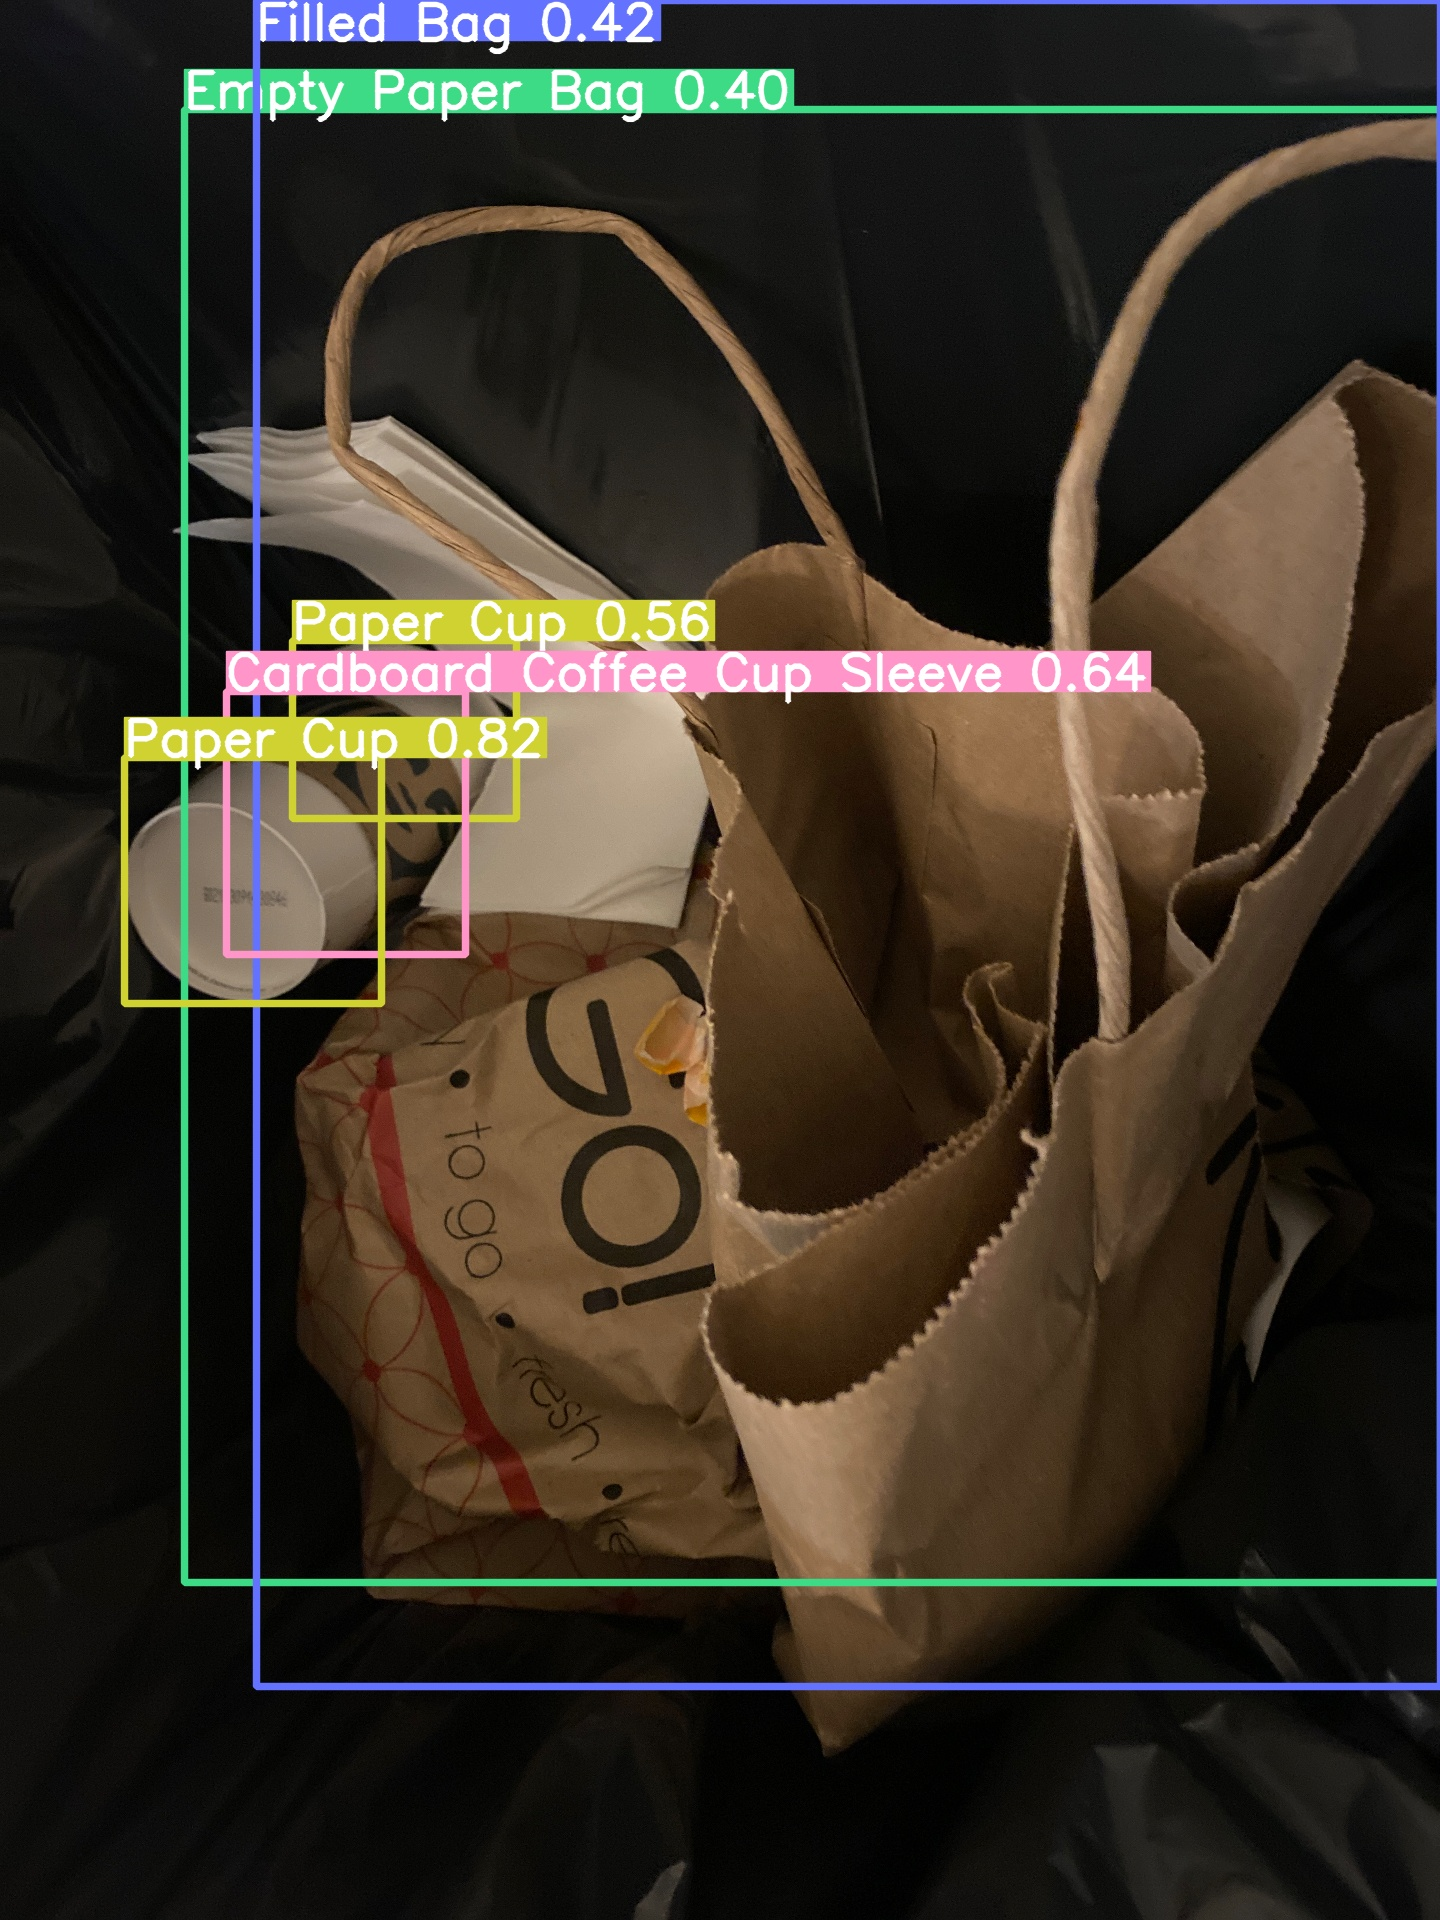

In [10]:
import os
import random
import json
from ultralytics import YOLO
from IPython.display import Image, display

# Load the trained model
model = YOLO('best.pt')

# Directories for images and cocojson
images_dir = './images'
coco_dir = './cocojson'

# Randomly select an image
random_image_name = random.choice(os.listdir(images_dir))
random_image_path = os.path.join(images_dir, random_image_name)

# Predict using the model
results = model(random_image_path)

# Find the corresponding json file
coco_json_name = os.path.splitext(random_image_name)[0] + '.json'
coco_json_path = os.path.join(coco_dir, coco_json_name)

# Function to count occurrences of each category in the JSON
def count_items_in_coco(coco_json_path):
    with open(coco_json_path) as f:
        data = json.load(f)

    category_names = {category['id']: category['name'] for category in data['categories']}

    # Count occurrences
    item_counts = {}
    for annotation in data['annotations']:
        category_id = annotation['category_id']
        category_name = category_names.get(category_id, 'Unknown Category')
        if category_name in item_counts:
            item_counts[category_name] += 1
        else:
            item_counts[category_name] = 1

    return item_counts

# Get the item counts from json
actual_counts = count_items_in_coco(coco_json_path)

# Account here that we are using ONLY 20 labels but the annotations still use 100 labels.
print("Correct item counts from annotations:")
for item, count in actual_counts.items():
    print(f"{item}: {count}")

for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    # result.show()  # display to screen
    result.save(filename='result.jpg')  # save to disk

display(Image(filename='result.jpg'))